In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import prepare_data

sns.set_style('whitegrid')

prices_df = prepare_data('data/wETH_ohlcv_data.csv', 'data/wETH_pt_ohlcv_data.csv', 'data/wETH_yt_ohlcv_data.csv')
prices_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/wETH_pt_ohlcv_data.csv'

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt

class Strategy(ABC):
    @abstractmethod
    def trade(self, prices_df, current_index):
        pass

In [ ]:
class Asset:
    def __init__(self):
        self.position = 0
        self.unrealized_gain = 0
        self.realized_gain = 0

    def update_unrealized_gain(self, price_change):
        self.unrealized_gain += self.position * price_change

    def execute_trade(self, delta_position, price_change):
        if delta_position != 0:
            # Calculate realized gain by considering the impact of the change in position
            self.realized_gain += delta_position * price_change
        self.position += delta_position

    def get_total_gain(self):
        return self.unrealized_gain + self.realized_gain

class YieldToken(Asset):
    def __init__(self):
        super().__init__()

    def update_daily_gain(self, annual_yield_rate, fee_rate=0.0003):
        # Calculate the daily yield rate based on the annual yield rate
        daily_yield_rate = (1 + annual_yield_rate) ** (1 / 365) - 1

        # Update the unrealized gain based on the daily yield rate
        self.realized_gain += (1 - fee_rate) * self.position * daily_yield_rate

class PrincipalToken(Asset):
    def __init__(self):
        super().__init__()

In [ ]:
class PendleBacktest:
    def __init__(self, prices_df):
        self.prices_df = prices_df
        self.underlying_token = Asset()
        self.pt_token = PrincipalToken()
        self.yt_token = YieldToken()
        self.profit = 0
        self._prep_data()

    def _prep_data(self):
        self.prices_df['underlying_price_change'] = self.prices_df['underlying_open'].diff().fillna(0)
        self.prices_df['pt_price_change'] = self.prices_df['pt_open'].diff().fillna(0)
        self.prices_df['yt_price_change'] = self.prices_df['yt_open'].diff().fillna(0)
        self.prices_df['cumulative_profit'] = 0

    def trade(self, strategy: Strategy):
        cumulative_profit = 0
        for timestamp, current_prices in self.prices_df.iterrows():
            # Update gains based on price changes and yield rates
            self.underlying_token.update_unrealized_gain(current_prices.underlying_price_change)

            self.pt_token.update_unrealized_gain(current_prices.pt_price_change)

            self.yt_token.update_unrealized_gain(current_prices.yt_price_change)
            self.yt_token.update_daily_gain(0.05) #TODO add yield rate to dataframe (this is yesterday's yield rate)

            # Get trade signals from the strategy
            underlying_delta, pt_delta, yt_delta = strategy.trade(self.prices_df, timestamp)

            # Execute trade and adjust unrealized gains
            self.underlying_token.execute_trade(underlying_delta, current_prices.underlying_price_change)
            self.pt_token.execute_trade(pt_delta, current_prices.pt_price_change)
            self.yt_token.execute_trade(yt_delta, current_prices.yt_price_change)

            # Update cumulative profit for each asset
            cumulative_profit = (self.underlying_token.get_total_gain() +
                                 self.pt_token.get_total_gain() +
                                 self.yt_token.get_total_gain())
            self.prices_df.at[timestamp, 'cumulative_profit'] = cumulative_profit

        # Liquidate positions to realize gains
        self.profit = cumulative_profit
        return self.profit

    def plot_profit(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        self.prices_df['cumulative_profit'].plot(ax=ax)
        ax.set_title('Cumulative Profit Over Time')
        ax.set_ylabel('Profit')
        ax.set_xlabel('Date')
        plt.show()

    def plot_detailed_profit(self):
        fig, ax = plt.subplots(2, 1, figsize=(12, 18))
        self.prices_df['cumulative_profit'].plot(ax=ax[0])
        self.prices_df[['underlying_open', 'pt_open', 'yt_open']].plot(ax=ax[1])
        ax[0].set_title('Cumulative Profit Over Time')
        ax[1].set_title('Asset Prices Over Time')
        ax[0].set_ylabel('Profit')
        ax[1].set_ylabel('Price')
        ax[0].set_xlabel('Date')
        ax[1].set_xlabel('Date')
        plt.show()

    def plot_yt_pt_invariant(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        self.prices_df['pt_open'].add(self.prices_df['yt_open']).plot(ax=ax, label='pt + yt')
        self.prices_df['underlying_open'].plot(ax=ax, label='underlying')
        ax.set_title('pt + yt vs Underlying Token Prices')
        ax.set_ylabel('Price')
        ax.set_xlabel('Date')
        ax.legend()
        plt.show()

Profit: 85112.73135852635


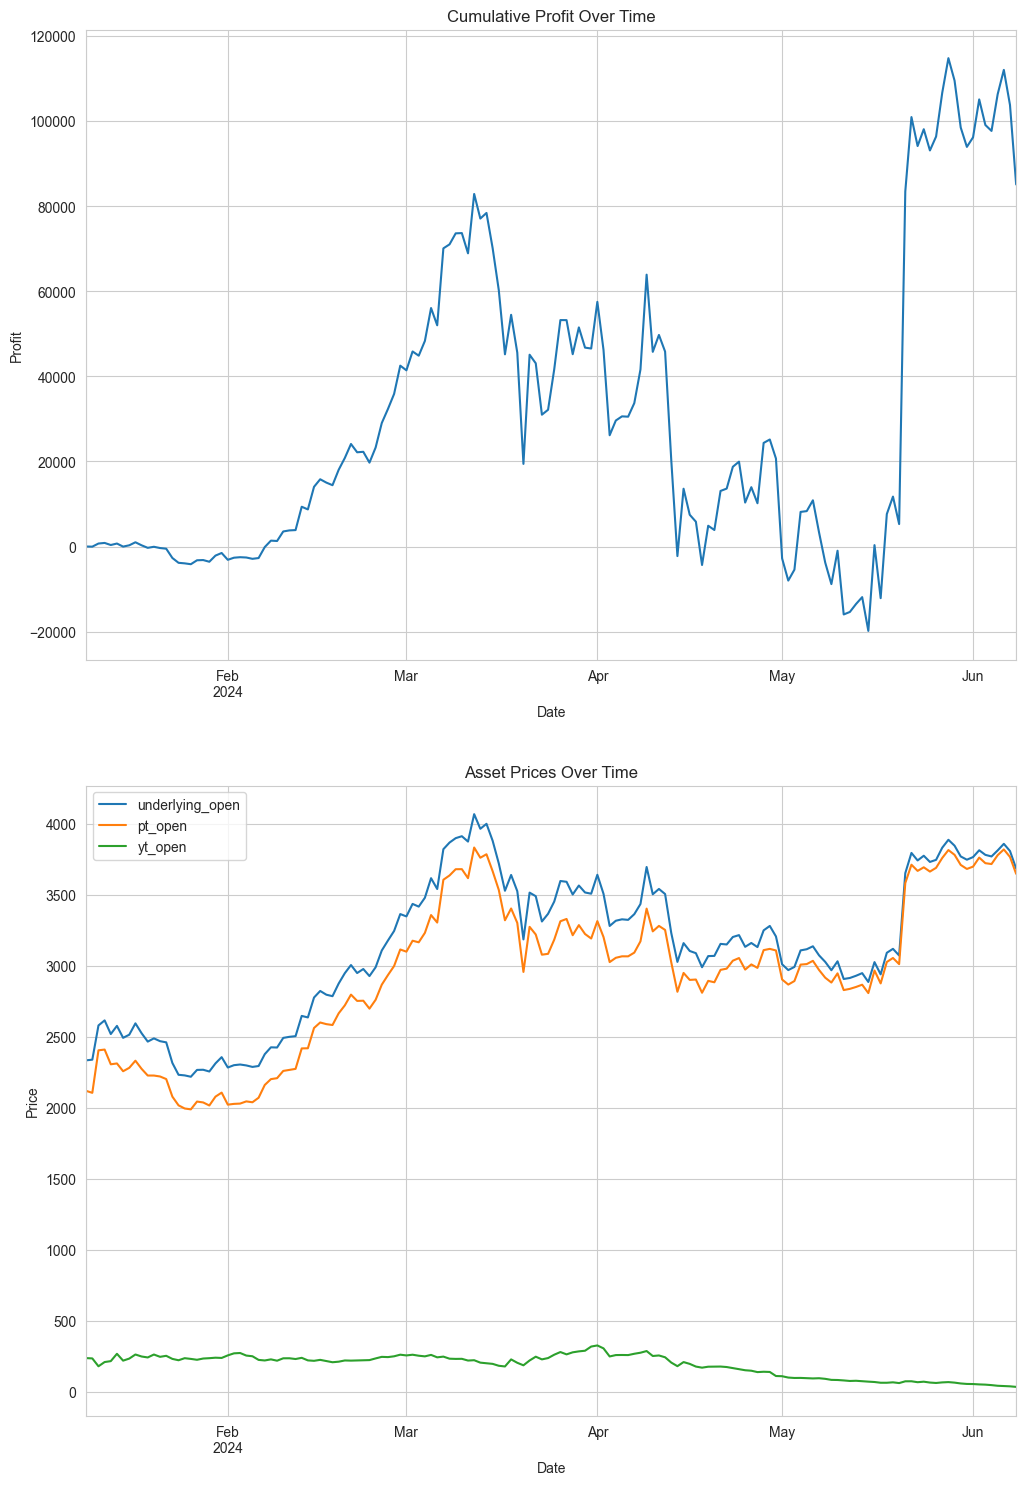

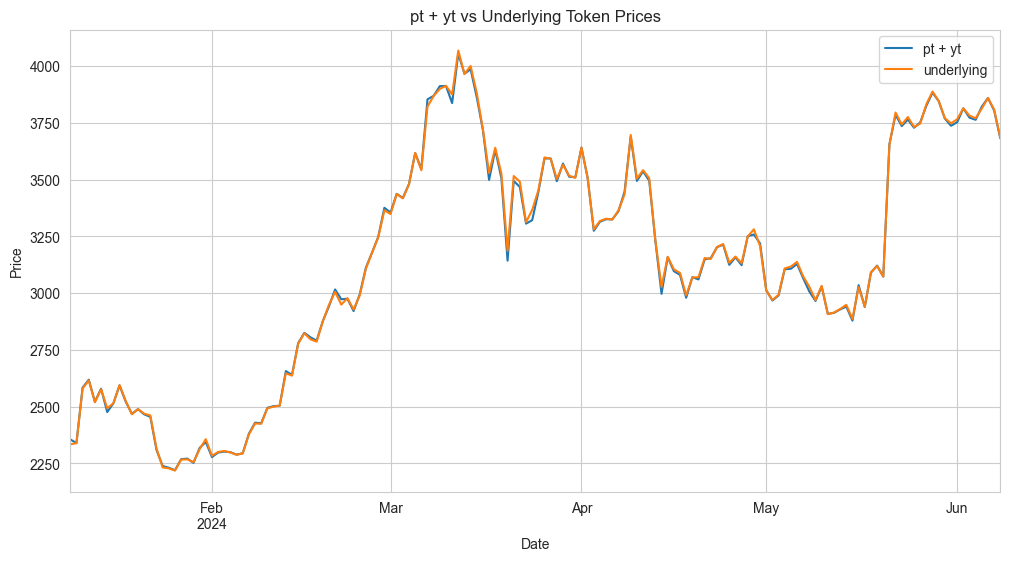

In [ ]:
class ExampleStrategy(Strategy):
    def trade(self, prices_df, current_index):
        return (0, 1, 1)

backtest = PendleBacktest(prices_df)
backtest.trade(ExampleStrategy())

print(f"Profit: {backtest.profit}")

backtest.plot_detailed_profit()

backtest.plot_yt_pt_invariant()
